In [93]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader
import utils

### データ準備

In [94]:
# TIFFファイルをJPEGに変換する関数
def tiff_to_jpeg(tiff_path, jpeg_path):
    from PIL import Image
    im = Image.open(tiff_path)
    im.convert('RGB').save(jpeg_path, 'JPEG')

# データセットのディレクトリ
dataset_dir = "/Users/hisashi/Desktop/git-hub/deep-learning/hymenoptera_data"

# TIFFファイルをJPEGに変換
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".tiff"):
            tiff_path = os.path.join(root, file)
            jpeg_path = os.path.join(root, file.replace(".tiff", ".jpg"))
            tiff_to_jpeg(tiff_path, jpeg_path)

### transform

In [81]:
# グレースケールからRGBへの変換関数
def grayscale_to_rgb(image):
    return image.convert('RGB')

# 検証データ用
val_transform = transforms.Compose([
    #transforms.Lambda(lambda x: grayscale_to_rgb(x)),  # グレースケールからRGBへの変換
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 訓練データ用
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

### DataSet

In [82]:
# ツリーのベースディレクトリ
data_dir = '/Users/hisashi/Desktop/git-hub/deep-learning/hymenoptera_data'
# 訓練データと検証データのディレクトリ
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
# 分類先クラスのリスト作成
classes = ['ants', 'bees']

# データセットの作成
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transform)
train_dataset2 = torchvision.datasets.ImageFolder(train_dir, transform=train_transform)   #イメージ表示用
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transform)

# データ件数確認
print('train_dataset:', len(train_dataset))
print('val_dataset:', len(val_dataset))

train_dataset: 244
val_dataset: 153


### 画像の確認

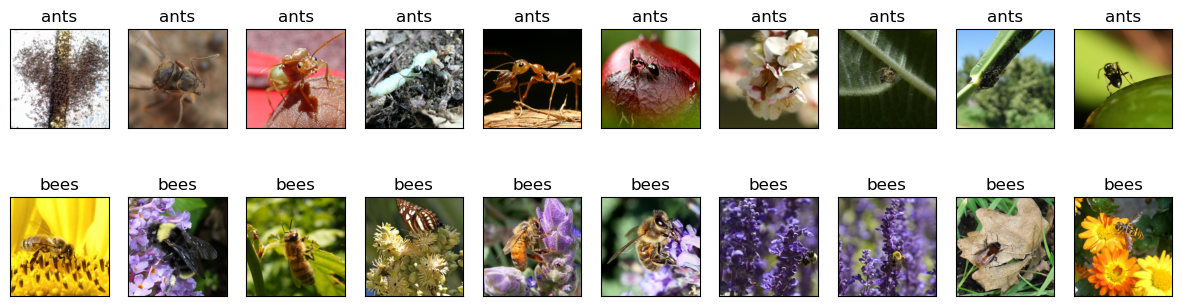

In [83]:
plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = val_dataset[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1) / 2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = val_dataset[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1) / 2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### DataLoader

In [84]:
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### model

In [85]:
# 事前学習済みモデルの読み込み
weights = models.EfficientNet_B1_Weights.IMAGENET1K_V1
efficientnet = models.efficientnet_b1(weights=weights)
# 2クラス分類用に出力サイズを2に変更
efficientnet.classifier = nn.Linear(1280, 2)
# structureの確認
efficientnet.parameters

<bound method Module.parameters of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
         

### 学習

In [86]:
# 学習率
lr = 0.001
# 損失関数
criterion = nn.CrossEntropyLoss()
# 最適化関数
optimizer = torch.optim.SGD(efficientnet.parameters(), lr=lr, momentum=0.9)
# epoch数
num_epochs = 10

In [87]:
train_losses, val_losses, val_accuracies = utils.learn(efficientnet, train_loader, val_loader, optimizer=optimizer, loss_func=criterion, num_epoch=10)

epoch: 0: train error: 0.6096557974815369, validation error: 0.48280112259089947, validation accuracy: 0.8999999910593033


epoch: 1: train error: 0.48585006952285764, validation error: 0.3682191325351596, validation accuracy: 0.9187499918043613


epoch: 2: train error: 0.4193418455123901, validation error: 0.31348248571157455, validation accuracy: 0.9124999903142452


epoch: 3: train error: 0.36922821700572966, validation error: 0.2791638020426035, validation accuracy: 0.9124999940395355


epoch: 4: train error: 0.3028573131561279, validation error: 0.23560370178893209, validation accuracy: 0.9062499925494194


epoch: 5: train error: 0.305101683139801, validation error: 0.23301646346226335, validation accuracy: 0.9249999932944775


epoch: 6: train error: 0.2883283531665802, validation error: 0.21773236617445946, validation accuracy: 0.9374999925494194


epoch: 7: train error: 0.27912066847085953, validation error: 0.19874182506464422, validation accuracy: 0.9437499940395355


epoch: 8: train error: 0.2593202644586563, validation error: 0.1874763574451208, validation accuracy: 0.9437499903142452


epoch: 9: train error: 0.22050467625260353, validation error: 0.18122434080578387, validation accuracy: 0.9499999918043613


In [88]:
val_accuracies

[0.8999999910593033,
 0.9187499918043613,
 0.9124999903142452,
 0.9124999940395355,
 0.9062499925494194,
 0.9249999932944775,
 0.9374999925494194,
 0.9437499940395355,
 0.9437499903142452,
 0.9499999918043613]

In [97]:
# データセットのダウンロード
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)

# データセットの確認
image, label = train_dataset[0]

In [103]:
image = np.array(image)
image

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [104]:
grayscale_to_rgb(image)

AttributeError: 'numpy.ndarray' object has no attribute 'convert'